# Proper GPs
Much here changed with the help of the `Flux Experimentation.ipynb` notebook. I'll try to make pretty, functional GPs here.

In [1]:
using LinearAlgebra
using Plots
using Distributions
using Random; Random.seed!(1234);

For now we will only consider GPs with zero mean and RBF kernel.

In [2]:
zero_mean() = x -> zeros(size(x))
constant_mean(m) = x -> zeros(size(x)) .+ m

constant_mean (generic function with 1 method)

In [3]:
rbf(l, σ_f) = 
    (x₁, x₂) -> σ_f.^2 .* exp.(- (x₁ .- x₂').^2 ./ l.^2)

rbf (generic function with 1 method)

Define a new structure `GP` with mean, kernel, and likelihood. It might be better to have a separate likelihood object, but for now this seems handy.

In [4]:
struct GP
    μ
    k
    σ_n
end

In [5]:
gp = GP(constant_mean([5.]), rbf([2.], [0.5]), [0.5])

GP(getfield(Main, Symbol("##5#6")){Array{Float64,1}}([5.0]), getfield(Main, Symbol("##7#8")){Array{Float64,1},Array{Float64,1}}([2.0], [0.5]), [0.5])

## Prior sample

In [6]:
prior(gp, X) = MultivariateNormal(gp.μ(X), gp.k(X, X) + 1e-6I)

prior (generic function with 1 method)

In [7]:
Xs = 0:0.01:10
prior_distribution = prior(gp, Xs)

FullNormal(
dim: 1001
μ: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0  …  5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Σ: [0.250001 0.249994 … 3.64991e-12 3.47199e-12; 0.249994 0.250001 … 3.83675e-12 3.64991e-12; … ; 3.64991e-12 3.83675e-12 … 0.250001 0.249994; 3.47199e-12 3.64991e-12 … 0.249994 0.250001]
)


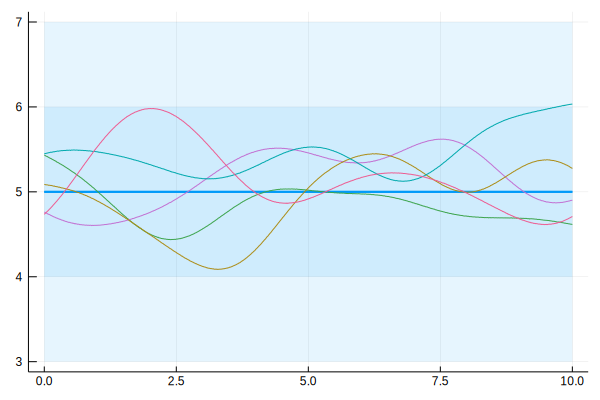

In [8]:
plot(
    Xs, prior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(prior_distribution.Σ)), 
    fillalpha=0.1, 
    leg=false,
)
plot!(
    Xs, prior_distribution.μ, 
    width=2, 
    ribbon=2(sqrt.(diag(prior_distribution.Σ)) .+ gp.σ_n), 
    fillalpha=0.1, 
    leg=false,
    color=1
)
plot!(Xs, rand(prior_distribution, 5))

## Posterior Sample
First generate some evidence from a single GP sample.

Then condition the GP on this evidence and plot the mean, variance, and some samples from this conditioned GP.

In [9]:
generating_gp = GP(constant_mean(-1.), rbf([0.5], [2]), [0.05])
n = 100
X = 1 .+ rand(n) * 8
generating_dist = prior(generating_gp, Xs)
idx = sample(1:length(Xs), n)
X = Xs[idx]
full_f = rand(generating_dist)
f = full_f[idx]
y = f .+ randn(size(f)) .* generating_gp.σ_n

100-element Array{Float64,1}:
  2.2410657326329706
 -3.8228675643433765
  2.7899008489379473
 -1.8720593553967386
  1.8388316233096316
  2.1887031070476977
 -3.5369079197659112
 -3.1640957519270914
 -3.138161294523259 
 -1.0531187602948056
 -1.5918903718417687
 -1.0820993660599185
 -1.8483023460272319
  ⋮                 
  2.206964668066476 
  1.8361127932374839
 -3.0998828972991257
  2.268632984132597 
 -3.196065540554504 
  2.9777138618774837
  3.702398884826781 
  2.566230759678284 
 -3.1761171614856787
 -3.4527904763825963
  3.8079128962518625
 -1.4677708715802518

In [10]:
function posterior(gp, X, y, Xs) 
    Δy = y - gp.μ(X)
    
    K = gp.k(X, X)
    Ks = gp.k(X, Xs)
    Kss = gp.k(Xs, Xs)

    K_inv = inv(K + gp.σ_n[1].^2 * I + 1e-6*I)

    cov = Kss - Ks' * K_inv * Ks
    mean = Ks' * K_inv * Δy
    
    return MultivariateNormal(gp.μ(Xs) + mean, Symmetric(cov + 1e-6I))
end

posterior (generic function with 1 method)

In [11]:
posterior_distribution = posterior(gp, X, y, Xs)

FullNormal(
dim: 1001
μ: [1.2827, 1.24691, 1.21122, 1.17564, 1.14018, 1.10483, 1.06962, 1.03454, 0.999591, 0.96479  …  -2.06819, -2.05198, -2.03561, -2.01909, -2.00241, -1.98558, -1.96858, -1.95143, -1.93413, -1.91667]
Σ: [0.0359185 0.0356497 … 8.36069e-6 8.30031e-6; 0.0356497 0.0353894 … 8.44012e-6 8.38348e-6; … ; 8.36069e-6 8.44012e-6 … 0.0281929 0.0284278; 8.30031e-6 8.38348e-6 … 0.0284278 0.0286709]
)


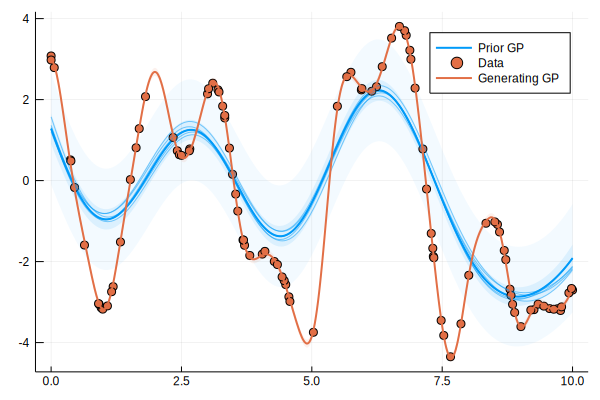

In [12]:
plot(
    Xs, posterior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(posterior_distribution.Σ)), 
    fillalpha=0.1, 
    label="Prior GP"
)
plot!(
    Xs, posterior_distribution.μ, 
    ribbon=2(sqrt.(diag(posterior_distribution.Σ)) .+ gp.σ_n), 
    fillalpha=0.05, 
    label="",
    color=1
)
scatter!(X, y, label="Data", color=2)
plot!(Xs, rand(posterior_distribution, 5), 
    label="",
    color=1, alpha=0.5,
)

plot!(Xs, full_f, width=2, 
    ribbon=2generating_gp.σ_n, 
    fillalpha=0.1, 
    label="Generating GP",
    color=2
)

## Hyperparameter optimization
Now for the fun part: Optimize the GP hyperparameters with Flux and Zygote!

In [13]:
using Flux, Zygote

In [14]:
function mll(gp, X, y)
    Δy = y - gp.μ(X)
    data_fit = -1/2 * Δy' * inv(gp.k(X, X) + gp.σ_n[1]^2 * I + 1e-6I) * Δy
    model_complexity = -1/2 * logdet(gp.k(X, X)+gp.σ_n[1].^2*I + 1e-6I)
    normalization_term = -length(y)/2 * log(2π)
    @assert length(data_fit) == 1
    @assert length(model_complexity) == 1
    @assert length(normalization_term) == 1
    return data_fit[1] + model_complexity[1] + normalization_term[1]
end
mll(gp, X, y)

-732.8732932644872

In [15]:
prior(gp) = logpdf(Gamma(2, 0.05), gp.k.l[1])
prior(gp)

-33.31538827233207

In [16]:
gp_gs, = gradient(m -> -mll(m, X, y), gp)

((μ = (m = [73.2369],), k = (l = [223.136], σ_f = [-1326.88]), σ_n = [-1280.18]),)

ADAM!

In [17]:
η = 0.01
opt = Flux.Optimise.ADAM(η)
println("[Epoch 0] ", gp.μ.m, gp.k.l, gp.k.σ_f, gp.σ_n)
for epoch=1:2000
    gp_gs, = gradient(m -> -mll(m, X, y), gp)
    Flux.Tracker.update!(opt, gp.k.l, gp_gs.k.l)
    Flux.Tracker.update!(opt, gp.μ.m, gp_gs.μ.m)
    Flux.Tracker.update!(opt, gp.k.σ_f, gp_gs.k.σ_f)
    Flux.Tracker.update!(opt, gp.σ_n, gp_gs.σ_n)
    if epoch % 100 == 0
        println("[Epoch $epoch] ", gp.μ.m, gp.k.l, gp.k.σ_f, gp.σ_n)
    end
end
println("True parameters:", generating_gp.μ.m, generating_gp.k.l, generating_gp.k.σ_f, generating_gp.σ_n)

[Epoch 0] [5.0][2.0][0.5][0.5]
[Epoch 100] [4.26299][1.39439][1.0712][0.935604]
[Epoch 200] [3.71428][0.995587][1.3362][0.947459]
[Epoch 300] [3.10641][0.667481][1.55658][0.652123]
[Epoch 400] [2.51527][0.527932][1.73273][0.0406759]
[Epoch 500] [1.96007][0.508681][1.85098][0.0417011]
[Epoch 600] [1.51399][0.509676][1.92806][0.0415927]
[Epoch 700] [1.14244][0.510496][1.98114][0.0415404]
[Epoch 800] [0.829338][0.511103][2.01849][0.0415051]
[Epoch 900] [0.565449][0.511557][2.04504][0.0414805]
[Epoch 1000] [0.344477][0.511901][2.06405][0.0414632]
[Epoch 1100] [0.161458][0.512167][2.07781][0.0414512]
[Epoch 1200] [0.0120044][0.51238][2.08791][0.0414428]
[Epoch 1300] [-0.108032][0.512557][2.09551][0.0414372]
[Epoch 1400] [-0.202677][0.512708][2.10141][0.0414336]
[Epoch 1500] [-0.275825][0.512843][2.10614][0.0414314]
[Epoch 1600] [-0.33117][0.512964][2.11005][0.0414302]
[Epoch 1700] [-0.372119][0.513073][2.11338][0.0414298]
[Epoch 1800] [-0.401715][0.513173][2.11626][0.0414298]
[Epoch 1900] [

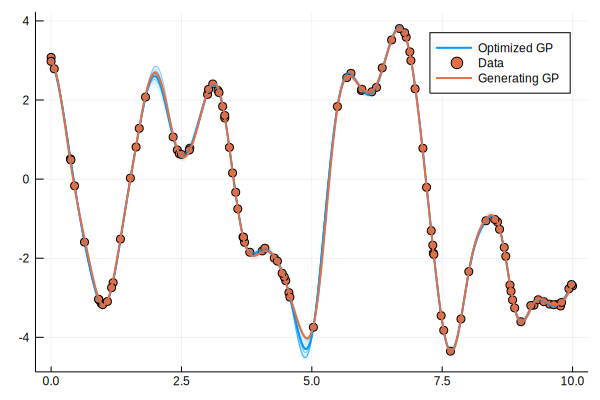

In [18]:
posterior_distribution = posterior(gp, X, y, Xs)
plot(
    Xs, posterior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(posterior_distribution.Σ)), 
    fillalpha=0.1, 
    label="Optimized GP"
)
plot!(
    Xs, posterior_distribution.μ, 
    ribbon=2(sqrt.(diag(posterior_distribution.Σ)) .+ gp.σ_n), 
    fillalpha=0.05, 
    label="",
    color=1
)

scatter!(X, y, label="Data", color=2)

plot!(Xs, rand(posterior_distribution, 5), 
    label="",
    color=1, alpha=0.5,
)

plot!(Xs, full_f, width=2, 
    ribbon=2generating_gp.σ_n, 
    fillalpha=0.1, 
    label="Generating GP",
    color=2
)